In [74]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((222219.771 -4050395.343, 224043.539 ...  -35.698392  -37.364474   

    bbox_east   bbox_west   place_id  osm_type   osm_id        lat        lon  \
0  175.903215  173.896328  298615087  relation  2094141 -36.541281  174.55061   

            display_name     class            type  importance  
0  Auckland, New Zealand  boundary  administrative        0.66  


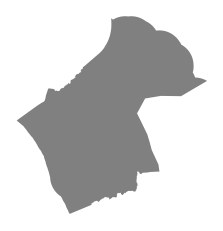

In [75]:
# Find Auckland location from osmx package
city = ox.geocode_to_gdf("Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [76]:
# Find Auckland BBox and download street informations
north, south, east, west = city_proj['bbox_north'][0],city_proj['bbox_south'][0],city_proj['bbox_east'][0],city_proj['bbox_west'][0]

gdf = ox.geometries.geometries_from_bbox(north,south,west,east,tags={'amenity':True,'shop':True})
gdf.drop(['addr:housenumber', 'addr:street',
          'phone','website',
          'wheelchair','addr:city',
          'payment:coins','brand',
          'brand:wikidata',
          'brand:wikipedia',
          'cuisine',
          'building',
          'parking',
          'takeaway',
          'healthcare',
          'operator','operator:wikidata','operator:wikipedia',
          'addr:postcode','opening_hours','opening_hours','addr:suburb','email','internet_access',
          'ref:linz:address_id','second_hand','access','fee','bicycle_parking','capacity','covered','nodes',
          'height','supervised','building:levels','layer','operator:type','payment:app','payment:credit_cards'
         ], axis=1, inplace=True)
projected_gdf = ox.project_gdf(gdf)

poi_node_df_columns = ['amenity', 'name', 'geometry',  'shop', 'clothes']
poi_node_df = pd.DataFrame(columns=poi_node_df_columns)

for df_index in projected_gdf.index.values:
    index_type = df_index[0]
    osm_node_id = df_index[1]
    # if index_type=="way":
    #     continue
    row = projected_gdf.loc[df_index]
    poi_node_df = pd.concat([poi_node_df,pd.DataFrame([row],
                                            columns=poi_node_df_columns,
                                            index=[osm_node_id])])
projected_poi_node_df = gpd.geodataframe.DataFrame(poi_node_df)
projected_poi_node_df.to_csv('./outputs/akl_projected_poi_node_df_with_ways.csv')
print(projected_poi_node_df.head())

            amenity                             name  \
850055554   parking                              NaN   
936116124      cafe  Macadamia Orchard Shop and Cafe   
140624820    school                  Waioneke School   
486569706   parking                              NaN   
1027056415  parking                              NaN   

                                                     geometry shop clothes  
850055554      POINT (263050.41753996955 -4065475.0257663005)  NaN     NaN  
936116124        POINT (262073.8345194602 -4055082.737913616)  NaN     NaN  
140624820   POLYGON ((258068.02414663936 -4047422.56991953...  NaN     NaN  
486569706   POLYGON ((259883.04466183294 -4049463.64958954...  NaN     NaN  
1027056415      POINT (246677.78759425564 -4001976.513771224)  NaN     NaN  


In [77]:
highway_G = ox.graph_from_bbox(
    north,south,west,east,
    network_type="walk",
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
)
projected_highway_G = ox.project_graph(highway_G)
print(projected_highway_G)

MultiDiGraph with 626825 nodes and 1284168 edges


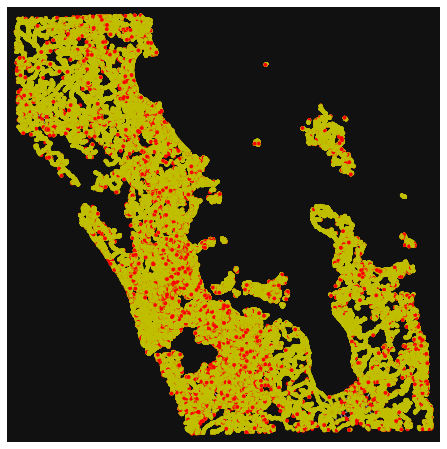

In [78]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(projected_highway_G, node) else "y" for node in projected_highway_G.nodes()]
fig, ax = ox.plot_graph(projected_highway_G, node_color=nc)

In [89]:
geo_x_list = []
geo_y_list = []
for row in projected_poi_node_df.iterrows():
    node_id, node_detail = row[0], row[1]
    coord = node_detail["geometry"]
    if type(coord) == Polygon or type(coord) == MultiPolygon or type(coord) == LineString:
        coord = coord.centroid.xy
        x,y= coord[0][0],coord[1][0]
    else:
        x,y =  coord.x,coord.y
    #print(x,y)
    geo_x_list.append(x)
    geo_y_list.append(y)
projected_poi_node_df["x"] = geo_x_list
projected_poi_node_df["y"] = geo_y_list
print(projected_poi_node_df)

              amenity                             name  \
850055554     parking                              NaN   
936116124        cafe  Macadamia Orchard Shop and Cafe   
140624820      school                  Waioneke School   
486569706     parking                              NaN   
1027056415    parking                              NaN   
...               ...                              ...   
1089353382    parking                              NaN   
1089353385    parking                              NaN   
1089353386    parking                              NaN   
1089363020       fuel                      Gull Tairua   
1089363021  fast_food                              NaN   

                                                     geometry shop clothes  \
850055554      POINT (263050.41753996955 -4065475.0257663005)  NaN     NaN   
936116124        POINT (262073.8345194602 -4055082.737913616)  NaN     NaN   
140624820   POLYGON ((258068.02414663936 -4047422.56991953...  NaN   

In [80]:
# 给POI node找到最近的路段，取出该POI node的Amenity类型 或者shop 类型
# 把node id，poi类型，边的node pair 存进一个DF
def find_edge_for_node(road_G,poi_df):
    columns = ["source","target","distance_to_edge",'amenity', 'name', 'geometry', 'shop', 'clothes','x','y']
    output_df = pd.DataFrame(columns=columns)
    road_nodes = road_G.nodes(data=True)

    poi_df_indexes = poi_df.index.values
    nearest_edges = ox.distance.nearest_edges(road_G, poi_df["x"],poi_df["y"],return_dist=False)

    for i in range(len(poi_df)):
        var_node_id = poi_df_indexes[i]
        var_node_detail = poi_df.iloc[i]

        var_x,var_y = var_node_detail["x"],var_node_detail["y"]
        var_u,var_v = nearest_edges[i][0],nearest_edges[i][1]
        #print(nearest_edges[i],var_u, var_v)
        distance_to_road_start = ox.distance.euclidean_dist_vec(var_y,var_x,
                                                              road_nodes[var_u]["y"],road_nodes[var_u]["x"])
        distance_to_road_end = ox.distance.euclidean_dist_vec(var_y,var_x,
                                                            road_nodes[var_v]["y"],road_nodes[var_v]["x"])
        average_distance_to_poi = (distance_to_road_start+ distance_to_road_end)/2

        #print(distance_to_road_start,distance_to_road_end,average_distance_to_poi)
        mapping_row = [var_u,var_v,average_distance_to_poi]
        #print(mapping_row)
        mapping_row= mapping_row+list(var_node_detail.to_dict().values())
        output_df = pd.concat([output_df,pd.DataFrame([mapping_row],
                                            columns=columns,
                                            index=[var_node_id])])
        if i % 1000 ==0:
            print("Done: ",i)
    return output_df

In [81]:
poi_mapping_df = find_edge_for_node(projected_highway_G,projected_poi_node_df)
poi_mapping_df.to_csv("./outputs/akl_poi_mapping.csv",index=False)
print(poi_mapping_df.head())

Done:  0
Done:  1000
Done:  2000
Done:  3000
Done:  4000
Done:  5000
Done:  6000
Done:  7000
Done:  8000
Done:  9000
Done:  10000
Done:  11000
Done:  12000
Done:  13000
Done:  14000
Done:  15000
Done:  16000
Done:  17000
Done:  18000
Done:  19000
Done:  20000
Done:  21000
Done:  22000
Done:  23000
Done:  24000
Done:  25000
Done:  26000
Done:  27000
Done:  28000
Done:  29000
Done:  30000
Done:  31000
Done:  32000
Done:  33000
Done:  34000
Done:  35000
Done:  36000
Done:  37000
Done:  38000
Done:  39000
Done:  40000
Done:  41000
Done:  42000
Done:  43000
Done:  44000
Done:  45000
Done:  46000
Done:  47000
Done:  48000
Done:  49000
                source      target  distance_to_edge  amenity  \
850055554   2199401768   648832120         20.616700  parking   
936116124   8404395922   703152736         40.784396     cafe   
140624820    820383063   820383007        246.560908   school   
486569706    820382570  4791618571        104.906785  parking   
1027056415  2132092690  2132092691    

In [82]:
#把street转成了node，并且加入了周围POI的type当作feature
def construct_street_nodes(highway_graph,poi_mapping_df):
    columns = ["source","target",'street_name','street_length']
    street_node_output_df = pd.DataFrame(columns=columns)

    for edge in highway_graph.edges(data=True):
        var_u,var_v,data = edge

        if data['reversed'] or "name" not in data.keys():
            continue
        #print("u,v: ",var_u,var_v)
        street_id,street_name,street_length = data["osmid"],data["name"],\
                                                       data["length"]
        mapping_row = [var_u,var_v,street_name,street_length]
        current_street_node_df = pd.DataFrame([mapping_row],
                                              columns=columns,
                                              index=[street_id])
        #print(u,v)
        matched_poi_df = poi_mapping_df[poi_mapping_df["source"]==var_u]
        matched_poi_df = matched_poi_df[matched_poi_df["target"]==var_v]

        # reverse u and v to find edge
        if len(matched_poi_df) ==0:
            matched_poi_df = poi_mapping_df[poi_mapping_df["source"]==var_v]
            matched_poi_df = matched_poi_df[matched_poi_df["target"]==var_u]
        # drop unneed columns
        #matched_poi_df= matched_poi_df.drop(labels=["source","target","name"],axis=1)
        # print(matched_poi_df)
        number_of_pois = len(matched_poi_df)

        # print("number_of_pois = {number_of_pois}".format(number_of_pois=number_of_pois))
        poi_to_edge_total_distance = 0.0
        # Go through poi_df and added up the poi on edge node
        for poi_data in matched_poi_df.iterrows():
            for key,value in poi_data[1].to_dict().items():
                # if key in ["source","target","name"]:
                #     print(street_name,key,value)
                # 把POI到节点的距离先加起来
                if key == "distance_to_edge":
                    poi_to_edge_total_distance += value
                    #print("dist" ,value)
                    continue
                if value is None or str(value)=="nan" or key == "geometry" or key in ["source","target","name","x","y"]:
                    continue

                if key == "shop" or key =="clothes":
                    combined_key = key
                elif value =="restaurant" or value =="cafe" or value =="pub" or value =="ice_cream" or value =="bar" or value == "food_court":
                    combined_key = "restaurant"
                elif value =="university" or value == "school":
                    combined_key = "school"
                elif value == "pharmacy" or value == "clinic" or value =="hospital":
                    combined_key = "healthcare"
                    #print(poi_data)
                else:
                    combined_key = key

                if combined_key not in current_street_node_df.columns:
                    current_street_node_df[combined_key] =0
                current_street_node_df[combined_key] +=1
        #print("Done Edge: ",edge)
        # 获得POI到街的平均距离
        if number_of_pois > 0:
            poi_to_edge_average_distance = poi_to_edge_total_distance / number_of_pois
            current_street_node_df["Average_POI_Distance"] = poi_to_edge_average_distance

        street_node_output_df = pd.concat([street_node_output_df,current_street_node_df])
    return street_node_output_df

In [83]:
street_node_df=construct_street_nodes(projected_highway_G,poi_mapping_df)
street_node_df["Average_POI_Distance"]=street_node_df["Average_POI_Distance"].fillna(street_node_df["street_length"])

street_node_df=street_node_df.fillna(0)
street_node_df.reset_index(inplace=True)

(458252, 14)


In [88]:
street_node_df[street_node_df["street_name"]=="Domain Road"]

,street_id,source,target,street_name,street_length,restaurant,x,y,Average_POI_Distance,amenity,school,shop,healthcare,clothes
8327,751450958,7024892928,1777873389,Domain Road,4.042,0.0,0.0,0.0,4.042000,0.0,0.0,0.0,0.0,0.0
8328,166333197,1777873396,7783591586,Domain Road,68.234,0.0,0.0,0.0,68.234000,0.0,0.0,0.0,0.0,0.0
8329,166333197,7783591586,7024892927,Domain Road,60.185,0.0,0.0,0.0,60.185000,0.0,0.0,0.0,0.0,0.0
8330,166333197,1777873407,1777873396,Domain Road,353.202,0.0,0.0,0.0,353.202000,0.0,0.0,0.0,0.0,0.0
8332,166333197,1777873437,1777873407,Domain Road,988.547,0.0,0.0,0.0,988.547000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277583,75593815,471913600,343315074,Domain Road,221.640,0.0,0.0,0.0,221.640000,0.0,0.0,0.0,0.0,0.0
282664,39385949,471908354,767865806,Domain Road,6.657,0.0,1.0,1.0,89.160955,1.0,0.0,0.0,0.0,0.0
282665,39385949,767865806,471913600,Domain Road,215.977,0.0,1.0,1.0,108.007633,1.0,0.0,0.0,0.0,0.0
291226,83013275,965854843,965854958,Domain Road,313.897,0.0,0.0,0.0,313.897000,0.0,0.0,0.0,0.0,0.0


In [ ]:
street_node_df = street_node_df.rename(columns = {'index':'street_id'})
print(street_node_df.shape)
street_node_df.to_csv("./outputs/akl_street_nodes.csv",index=False)

In [84]:
def construct_street_edges(nodes_df):
    result_dict = {}
    for data in nodes_df.iterrows():
        street_index,node = data[0],data[1]
        var_u,var_v = node['source'],node['target']
        result_dict=find_neighbour_streets(street_index,node,nodes_df,var_u,var_v,result_dict)
        result_dict=find_neighbour_streets(street_index,node,nodes_df,var_v,var_u,result_dict)
        #print(u,v)
        #print(edge_dict)
        #break
    return result_dict

def find_neighbour_streets(node_index,node_data,nodes_df, source,target, param_edge_dict):
        same_source_neighbours_df = nodes_df[nodes_df["source"]==source]
        same_source_neighbours_df = same_source_neighbours_df[same_source_neighbours_df["target"]!=target]

        same_target_neighbours_df = nodes_df[nodes_df["target"]==source]
        same_target_neighbours_df = same_target_neighbours_df[same_target_neighbours_df["source"]!=target]
        # if street_index == 2298:
        #     print(same_source_neighbours_df)
        #     print(same_target_neighbours_df)
        # Loop through neighbours with same source
        for neighbour_data in same_source_neighbours_df.iterrows():
            neighbour_index,neighbour = neighbour_data[0],neighbour_data[1]
            # nodes within same street can not have same source or target
            edge_key = (node_index,neighbour_index)
            reverse_edge_key=(neighbour_index,node_index)
            edge_distance =  node_data['Average_POI_Distance'] + neighbour['Average_POI_Distance']

            if edge_key in param_edge_dict:
                if param_edge_dict[edge_key]!=edge_distance:
                    raise Exception("Multiple Edge Distances with same source")
                continue

            param_edge_dict[edge_key] = edge_distance
            param_edge_dict[reverse_edge_key] = edge_distance

        # Loop through neighbours with same target
        for neighbour_data in same_target_neighbours_df.iterrows():
            neighbour_index,neighbour = neighbour_data[0],neighbour_data[1]
            # nodes within same street can not have same source or target
            edge_key = (node_index,neighbour_index)
            reverse_edge_key=(neighbour_index,node_index)
            edge_distance =  node_data['Average_POI_Distance'] + neighbour['Average_POI_Distance']

            if edge_key in param_edge_dict:
                if param_edge_dict[edge_key]!=edge_distance:
                    raise Exception("Multiple Edge Distances with same source")
                continue

            param_edge_dict[edge_key] = edge_distance
            param_edge_dict[reverse_edge_key] = edge_distance
        return param_edge_dict

In [85]:
edge_dict = construct_street_edges(street_node_df)
edge_df = pd.DataFrame(columns=["source_street","target_street","distance"])
for k,v in edge_dict.items():
    row = pd.DataFrame([[k[0],k[1],v]],columns=["source_street","target_street","distance"])
    #print(row)
    edge_df = pd.concat([edge_df,row])
edge_df.to_csv("./outputs/akl_street_edges.csv",index=False)
print(edge_df)

   source_street target_street  distance
0              0             2    96.873
0              2             0    96.873
0              0             1   100.787
0              1             0   100.787
0              1             3   118.706
..           ...           ...       ...
0         458249        458248   310.398
0         458249        458250   328.777
0         458250        458249   328.777
0         458250        458251   493.528
0         458251        458250   493.528

[1004718 rows x 3 columns]


        street_id      source      target      street_name  street_length  \
0       984794487   279051892  2852049636  South Head Road         32.641   
1       984794487  2852049636   279051893  South Head Road         68.146   
2       984794487   279051903   279051892  South Head Road         64.232   
3       984794487   279051893   279051895  South Head Road         50.560   
4       984794487   279051895  7556143502  South Head Road         20.232   
...           ...         ...         ...              ...            ...   
458247  154664117  9960768752  9960768738    Bradshaw Road         25.652   
458248  242805474  9994920519  9994920518      Wainui Road        166.770   
458249  242805474  9994920520  9994920519      Wainui Road        143.628   
458250  242805474  9994920521  9994920520      Wainui Road        185.149   
458251  242805474  9994920523  9994920521      Wainui Road        308.379   

        restaurant    x    y  Average_POI_Distance  amenity  school  shop  